# Non-Equilibrium Green's functions and Transport

## Quantum Matter - Materials & Concepts Summer School 2022

### Hands-on session

In this session, we will

1. Evaluate the self-energy due to a semi-infinite 1D tight-binding chain 
2. Evaluate transport through a single level system
3. Explore the effects of electron-electron interactions at a mean-field level

This notebook uses the [Julia](https://julialang.org) programming language.
It is convenient to load the package `LinearAlgebra`, to solve linear algebra problems. 
For plotting we will use the package `PyPlot`.

In [2]:
using Pkg # this will load Julia's package manager
Pkg.add("PyPlot") # this will download and install the package PyPlot
Pkg.add("QuadGK") # pacage to do integrations
#(it only needs to be run if the package is not installed)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [3]:
using LinearAlgebra, PyPlot, QuadGK

## 1. Evaluation of self-energy of a semi-infinite tight-binding chain

### 1.1. Bandstruture evaluation of a 1D tight-binding chain

We will consider a infinite chain, described by the Hamiltonian

$$
H_{\text{infinito}}=\left[\begin{array}{cccccc}
 & \ddots\\
\ddots & \ddots & \boldsymbol{v}\\
 & \boldsymbol{v}^{\dagger} & \boldsymbol{h} & \boldsymbol{v}\\
 &  & \boldsymbol{v}^{\dagger} & \boldsymbol{h} & \boldsymbol{v}\\
 &  &  & \boldsymbol{v}^{\dagger} & \ddots & \ddots\\
 &  &  &  & \ddots
\end{array}\right].
$$

To evaluate the bandstructure, we must solve the eigenvalue problem:

$$
\left(\boldsymbol{h}+e^{ik}\boldsymbol{v}+e^{-ik}\boldsymbol{v}^{\dagger}\right)\Psi_{k}=E_{k}\Psi_{k}.
$$

### Problem 1.1.a
Write a function that given $\boldsymbol{h}$ and $\boldsymbol{v}$ evaluates the bandstructure for a infinite 1D chain.

For convinience we can store the Hamiltonian of the chain with the structure:

In [4]:
function spectrum(h, v, k)
    
    Hk = h + v*cis(k) + adjoint(v)*cis(-k)
    
    energies = eigvals(Hk)
    
    return energies
end


function bandstructure(h, v, kpts)
    
    bands = zeros(size(h, 1), length(kpts))
    
    for (i, k) in enumerate(kpts)
        
        vals = spectrum(h, v, k)
        for (n, e) in enumerate(vals)
            bands[n, i] = e
        end
    
    end
    
    return bands
    
end 

bandstructure (generic function with 1 method)

In [5]:
kpts = range(-pi, stop =  pi, length = 100)
bandas = bandstructure(0, -1.0, kpts)

1×100 Matrix{Float64}:
 2.0  1.99597  1.98391  1.96386  1.9359  …  1.96386  1.98391  1.99597  2.0

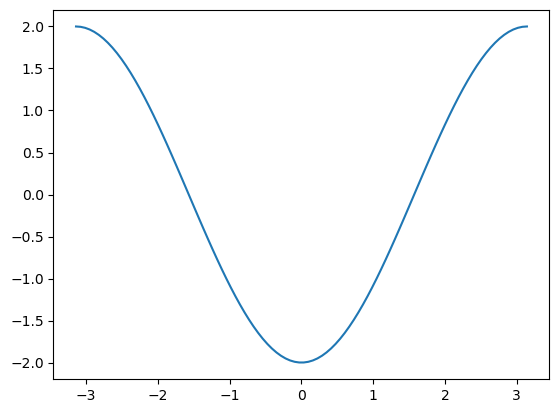

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f94be7e9730>

In [6]:
plot(kpts, bandas[1, :])

## 1.2 Recursive evaluation of the self-energy

Now let us consider a semi-infinite chain, with Hamiltonian:

$$
H_{\text{semi}}=\left[\begin{array}{cccc}
\boldsymbol{h} & \boldsymbol{v}\\
\boldsymbol{v}^{\dagger} & \boldsymbol{h} & \boldsymbol{v}\\
 & \boldsymbol{v}^\dagger & \ddots & \ddots\\
 & \ddots
\end{array}\right]
$$

We want to evaluate the self-energy: $\Sigma^R = \boldsymbol{v}\boldsymbol{g}_{1,1}^R \boldsymbol{v}^\dagger$,

where the Green's function is solution of:

$$
\left[\begin{array}{cccc}
E-\boldsymbol{h} & -\boldsymbol{v}\\
-\boldsymbol{v}^{\dagger} & E-\boldsymbol{h} & -\boldsymbol{v}\\
 & -\boldsymbol{v}^{\dagger} & \ddots & \ddots\\
 &  & \ddots
\end{array}\right]\left[\begin{array}{cccc}
\boldsymbol{g}_{1,1}^{R} & \boldsymbol{g}_{1,2}^{R} & \boldsymbol{g}_{1,3}^{R} & \cdots\\
\boldsymbol{g}_{2,1}^{R} & \boldsymbol{g}_{2,2}^{R} & \boldsymbol{g}_{2,3}^{R} & \cdots\\
\boldsymbol{g}_{3,1}^{R} & \boldsymbol{g}_{3,2}^{R} & \boldsymbol{g}_{3,3}^{R} & \cdots\\
\vdots & \vdots & \vdots & \ddots
\end{array}\right]=\left[\begin{array}{cccc}
\boldsymbol{1}\\
 & \boldsymbol{1}\\
 &  & \boldsymbol{1} & \ddots\\
 &  & \ddots & \ddots
\end{array}\right]
$$

The recursive method is based on the fact that a semi-infinite chain can be seen as one site coupled to another equal semi-infinite chain. Treating the hopping between the first site and the rest of the chain as a perturbation, we obtain the Lippmann-Schwinger equations: 

$$
\begin{align*}
\boldsymbol{g}^{R} & =\tilde{\boldsymbol{g}}^{R}+\tilde{\boldsymbol{g}}^{R}\cdot\boldsymbol{V}\cdot\boldsymbol{g}^{R}\\
\boldsymbol{g}^{R} & =\tilde{\boldsymbol{g}}^{R}+\boldsymbol{g}^{R}\cdot\boldsymbol{V}\cdot\tilde{\boldsymbol{g}}^{R}
\end{align*}
$$

where:
$$
\tilde{\boldsymbol{g}}^{R}=\left[\begin{array}{cccc}
E-\boldsymbol{h} & \boldsymbol{0}\\
\boldsymbol{0} & E-\boldsymbol{h} & -\boldsymbol{v}\\
 & -\boldsymbol{v}^{\dagger} & \ddots & \ddots\\
 &  & \ddots
\end{array}\right]^{-1}
$$

is the Green's functions of the system where the first site is desconnected from the rest of the chain and
$$
\boldsymbol{V}=\left[\begin{array}{cccc}
\boldsymbol{0} & \boldsymbol{v}\\
\boldsymbol{v}^{\dagger} & \boldsymbol{0} & \boldsymbol{0}\\
 & \boldsymbol{0} & \boldsymbol{0} & \ddots\\
 &  & \ddots & \ddots
\end{array}\right]
$$

connects the first site to the rest of the chain.

From these we obtain the following relations:
$$
\begin{align*}
\boldsymbol{g}_{1,1}^{R} & =\tilde{\boldsymbol{g}}_{1,1}^{R}+\tilde{\boldsymbol{g}}_{1,1}^{R}\cdot\boldsymbol{V}_{1,2}\cdot\boldsymbol{g}_{2,1}^{R}\\
\boldsymbol{g}_{2,1}^{R} & =\tilde{\boldsymbol{g}}_{2,2}^{R}\cdot\boldsymbol{V}_{2,1}\cdot\boldsymbol{g}_{1,1}^{R}
\end{align*}
$$
Which can be combined yielding:
$$
\boldsymbol{g}_{1,1}^{R}=\left[E-\boldsymbol{h}-\boldsymbol{v}\cdot\tilde{\boldsymbol{g}}_{2,2}^{R}\cdot\boldsymbol{v}^{\dagger}\right]^{-1}
$$

It appears we have not made any progress, since we do not know $\tilde{\boldsymbol{g}}_{2,2}^{R}$. However, we notice that $\tilde{\boldsymbol{g}}_{2,2}^{R}$ is the on-site Green's function for the first site of a semi-infinite chain, which is preciselly what we wish to evaluate. Therefore, we have have that $\tilde{\boldsymbol{g}}_{2,2}^{R} = \boldsymbol{g}_{1,1}^{R}$, such that we obtain the self-consistent relation

$$
\boldsymbol{g}_{1,1}^{R}=\left[E-\boldsymbol{h}-\boldsymbol{v}\cdot\boldsymbol{g}_{1,1}^{R}\cdot\boldsymbol{v}^{\dagger}\right]^{-1}
$$

By solving this equation, we can evalluate the self-energy.

### Problem 1.2.a
For the case of a single-orbital nearest neighbour tight-binding chain rewrite the above equation as a quadratic equation for $g_{1,1}^R$ and solve it analytically. From the two possible solutions, select the retarded one as the solution in which for a complext energy argument, $E + i \eta$ with $\eta \rightarrow 0^+$, the imaginary part of $g_{1,1}^R(E+i\eta)$ is negative.

You should obtain
$$
g^{R}(E)=\frac{1}{t}\left[\left(\frac{E-\epsilon_{0}}{2t}\right)-i\sqrt{1-\left(\frac{E+i0^{+}-\epsilon_{0}}{2t}\right)^{2}}\right]
$$


Study the Green's function for $\left|E-\epsilon_{0}\right|\lessgtr2t$ and make a plot of the real and imaginary parts.

In [7]:
function gr(E)
    
    if abs(E) < 2
        
        return E/2 - 1im*sqrt(1-(E/2)^2)
        
    else
        
        return E/2 - sign(E)*sqrt((E/2)^2-1)
        
    end
    
end

gr (generic function with 1 method)

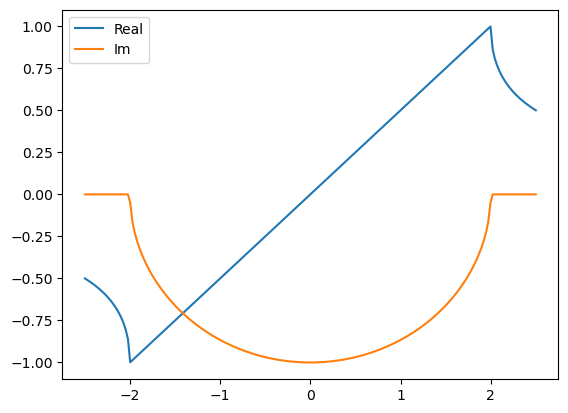

PyObject <matplotlib.legend.Legend object at 0x7f94b40d5df0>

In [8]:
Es = range(-2.5, 2.5, length = 200)
grs = gr.(Es)

plot(Es, real.(grs), label = "Real")
plot(Es, imag.(grs), label = "Im")
legend()

### Problem 1.2.b 
Implement a code that solves the self-consistent equation iterativelly. Compare the numerical result with the analytic one. 
**Hint:** Add a small positive imaginary part to the energy,  $E \rightarrow E + i \eta$, in order to stabelise the iterative method.

In [9]:
function lead_gf_recursive(h, v, E; eta = 0.01, niter = 200)
    
    Σold = v*(((E + im*eta)*I - h)\adjoint(v))
    Σnew = v*(((E + im*eta)*I - h - Σold)\adjoint(v))
    η = eta
    for n in 1:niter
        
        Σold = Σnew
        Σnew = v*(((E + im*eta)*I - h - Σold)\adjoint(v))
        
    end
    
    return inv((E + im*eta)*I - h - Σnew)
end

lead_gf_recursive (generic function with 1 method)

In [10]:
Es = range(-2.5, 2.5, length = 200)
selfenergy_recursive = [lead_gf_recursive(0.0, -1.0, E; eta = 0.01, niter = 1000) for E in Es]
;

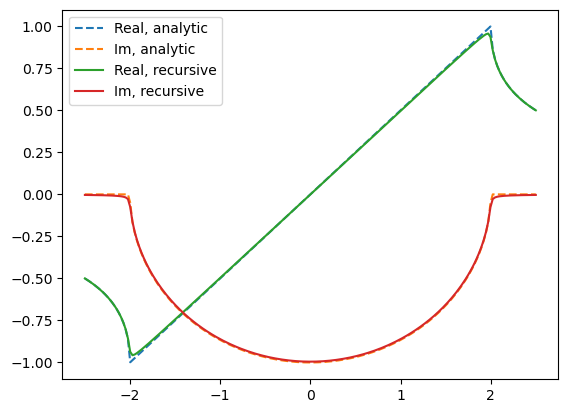

PyObject <matplotlib.legend.Legend object at 0x7f94b4069490>

In [11]:
plot(Es, real.(grs), label = "Real, analytic", "--")
plot(Es, imag.(grs), label = "Im, analytic", "--")

plot(Es, [real.(g[1]) for g in selfenergy_recursive], label = "Real, recursive")
plot(Es, [imag.(g[1]) for g in selfenergy_recursive], label = "Im, recursive")
legend()

## 2. Transport using the Caroli formula

Let us consider a two-contact system described by the Hamiltonian
$$
H_{\text{2-contact}}=\left[\begin{array}{ccc}
\boldsymbol{H}_{C} & \boldsymbol{V}_{C,L} & \boldsymbol{V}_{C,R}\\
\boldsymbol{V}_{L,C} & \boldsymbol{H}_{L}\\
\boldsymbol{V}_{R,C} &  & \boldsymbol{H}_{R}
\end{array}\right]
$$

The Caroli formula expresses the transmitance in terms of Green's functions as A fórmula de Caroli escreve a transmitância como:

$$
\mathcal{T}(E)=\text{Tr}\left[\boldsymbol{G}^{A}(E)\boldsymbol{\Gamma}_{R}(E)\boldsymbol{G}^{R}(E)\boldsymbol{\Gamma}_{L}(E)\right]
$$

where

$$
\boldsymbol{G}^{R}(E)=\left[E-\boldsymbol{H}_{C}-\boldsymbol{\Sigma}_{L}^{R}(E)-\boldsymbol{\Sigma}_{R}^{R}(E)\right]^{-1},
$$

$\boldsymbol{G}^{A}(E)=\left[\boldsymbol{G}^{R}(E)\right]^{\dagger}$ and

$$
\boldsymbol{\Gamma}_{\ell}(E)=i\left[\boldsymbol{\Sigma}_{\ell}^{R}(E)-\boldsymbol{\Sigma}_{\ell}^{A}(E)\right]
$$

### Problem 2.a
Implement the above equations in order to evaluate the transmitance. As an example, evaluate the transmitance through a single-level with energy $\epsilon_0 = 0.5$ that is connected to the left and right contacts with the hoppings $t_{C,L} = t_{C, R} = -0.2$. Compare this with the analytic result.

In [12]:
struct SemiInfiniteChain
    h::Float64
    v::Float64
end

In [13]:
struct TwoTerminalSystem{Tc, Tl, Tr}
    Hc::Tc
    Vcl::Tl
    Vcr::Tr
    leftlead::SemiInfiniteChain
    rightlead::SemiInfiniteChain
end

In [14]:
chain = SemiInfiniteChain(0, -1)

SemiInfiniteChain(0.0, -1.0)

In [15]:
function greens_function(chain::SemiInfiniteChain, E)
    
    ϵ0 = chain.h
    t = -chain.v
    
    z = (E-ϵ0)/(2*t)
    
    if abs(z) < 1
        
        return (z - 1im*sqrt(1-z^2))/t
        
    else
        
        return (z - sign(z)*sqrt(z^2-1))/t
        
    end
end
    

greens_function (generic function with 1 method)

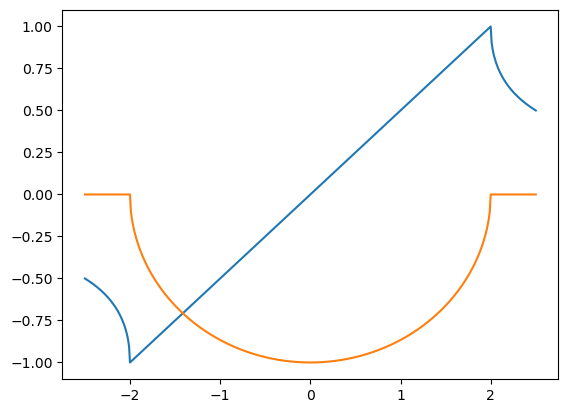

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f94ae21ca90>

In [16]:
plot(
    range(-2.5, stop = 2.5, step = 0.01), 
    [real(greens_function(chain, e)) for e in range(-2.5, stop = 2.5, step = 0.01)]
)
plot(
    range(-2.5, stop = 2.5, step = 0.01), 
    [imag(greens_function(chain, e)) for e in range(-2.5, stop = 2.5, step = 0.01)]
)

In [17]:
function transmitance_caroli(sys::TwoTerminalSystem, E)
    
    Σleft = sys.Vcl*greens_function(sys.leftlead, E)*sys.Vcl'
    Σright = sys.Vcr*greens_function(sys.rightlead, E)*sys.Vcr'
    
    
    Γright = im*(Σright - adjoint(Σright))
    Γleft = im*(Σleft - adjoint(Σleft))
    

    LR = E*I - sys.Hc - Σleft - Σright
    LA = E*I - sys.Hc - adjoint(Σleft) - adjoint(Σright)
    
    Qright = LR\Γright
    Qleft = LA\Γleft
    
    return real(tr(Qright*Qleft))
end

transmitance_caroli (generic function with 1 method)

In [18]:
function Σr(E; t = -1.0) 
    if abs(E) < 2
        
        return t^2*(E/2 - 1im*sqrt(1-(E/2)^2))
        
    else
        
        return t^2*(E/2 - sign(E)*sqrt((E/2)^2-1))
        
    end
    
end

function Σa(E; t = -1.0) 
    if abs(E) < 2
        
        return t^2*(E/2 + 1im*sqrt(1-(E/2)^2))
        
    else
        
        return t^2*(E/2 - sign(E)*sqrt((E/2)^2-1))
        
    end
    
end

function Gr(E; E0 = 0.5, t = -1.0)
    
    return 1/(E - E0 - 2*Σr(E; t = t))
    
end

function Ga(E; E0 = 0.5, t = -1.0)
    
    return 1/(E - E0 - 2*Σa(E; t = t))
    
end

function Tanalytic(E; E0 = 0.5, t = -1.0)
    
    Γ = -2*imag(Σr(E; t = t))
    
    return abs2(Gr(E; E0 = E0, t = t))*Γ*Γ
    
end

Tanalytic (generic function with 1 method)

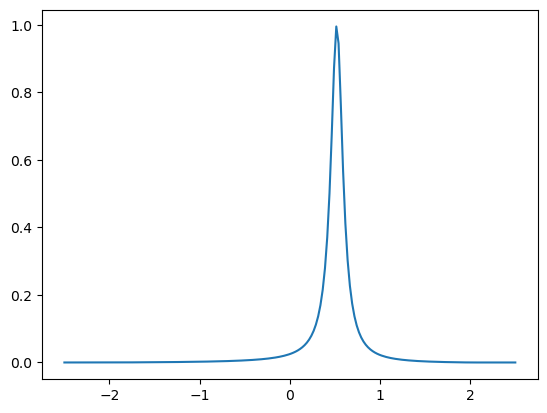

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f94ad6d96a0>

In [19]:
plot(Es, [Tanalytic(e; E0 = 0.5, t = -0.2) for e in Es])

In [20]:
leftlead = SemiInfiniteChain(0, -1)
rightlead = SemiInfiniteChain(0, -1)

twoterminal = TwoTerminalSystem(0.5, -0.2, -0.2, leftlead, rightlead)
;

In [21]:
Es = range(-2, 2, length = 200)
Tcaroli = [transmitance_caroli(twoterminal, E) for E in Es]
;

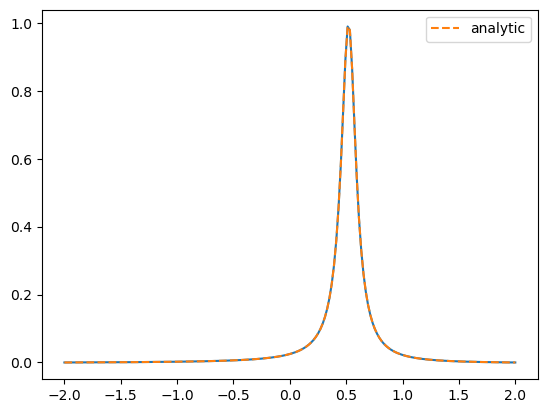

PyObject <matplotlib.legend.Legend object at 0x7f94ad6a8a90>

In [22]:
plot(Es, Tcaroli)
plot(Es, [Tanalytic(e; E0 = 0.5, t = -0.2) for e in Es], "--",label = "analytic")
legend()

##

### Problem 2.b
A sometimes useful approximation is the so called "Wide Band Limit" (WBL) approximation, which consists in ignoring the energy dependence of the leads self energy, and consider its imaginary/anti-hermitian part, i.e,

$$
\Sigma^R_{\ell}(\omega) \simeq -\frac{i}{2}\Gamma_{\ell}(\omega_0)
$$

where $\omega_0$ is some reference energy, choosen to be close to the Fermi levels of the leads. 

Use the WBL for the single-level problem connect to two leads. Make the approximation

$$
\Sigma^R_{\ell}(\omega) \simeq -\frac{i}{2}\Gamma_{\ell}(0)
$$

And compare the result with the previous one.

In [23]:
function transmitance_caroli_WBL(sys::TwoTerminalSystem, E)
    
    Σleft = sys.Vcl*greens_function(sys.leftlead, 0)*sys.Vcl'
    Σright = sys.Vcr*greens_function(sys.rightlead, 0)*sys.Vcr'
    
    
    Γright = im*(Σright - adjoint(Σright))
    Γleft = im*(Σleft - adjoint(Σleft))
    

    LR = E*I - sys.Hc - Σleft - Σright
    LA = E*I - sys.Hc - adjoint(Σleft) - adjoint(Σright)
    
    Qright = LR\Γright
    Qleft = LA\Γleft
    
    return real(tr(Qright*Qleft))
end

transmitance_caroli_WBL (generic function with 1 method)

In [24]:
Es = range(-2, 2, length = 200)
Tcaroli = [transmitance_caroli(twoterminal, E) for E in Es]
Tcaroli_WBL = [transmitance_caroli_WBL(twoterminal, E) for E in Es]
;

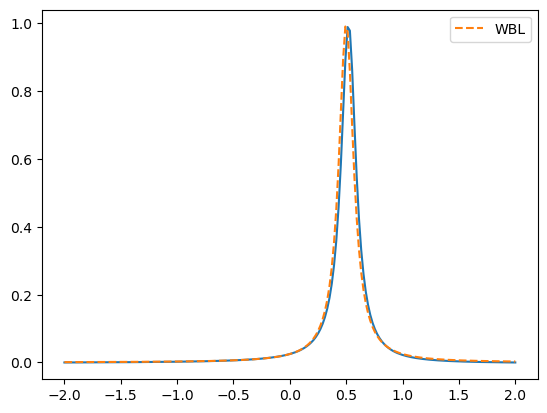

PyObject <matplotlib.legend.Legend object at 0x7f94ae745580>

In [25]:
plot(Es, Tcaroli)
plot(Es, Tcaroli_WBL, "--", label = "WBL")
legend()

# 3. Electron-electron interactions at the mean field level

Consider that the Hamiltonian for the centra region is given by

$$
H_C = \sum_{\sigma = \uparrow, \downarrow}\epsilon_0 d_{\sigma}^\dagger d_{\sigma} + U n_{\uparrow} n_{\downarrow}
$$

where $n_\sigma = d_{\sigma}^\dagger d_{\sigma}$ is the electron number operator for spin $\sigma$.

At mean field, we obtain the Hamiltonian

$$
H_C^{MF} = \sum_{\sigma} \epsilon_{\sigma}^{MF} d_{\sigma}^\dagger d_{\sigma}
$$

where $\epsilon_{\sigma}^{MF} = \epsilon_0 + U \left\langle n_{\bar{\sigma}}\right\rangle$

Use the mean field Hamiltonian to evaluate the retarded/advanced Green's functions, the Keldysh equation to express $G^{<}$ and the fact that $\left\langle n_{\sigma}\right\rangle = \int\frac{d\omega}{2\pi} (-i)G^{<}_{\sigma}(\omega)$ to setup a set of self-consistent equations. Solve theses iterativelly. For simplicity, use the WBL approximation.

Use the menad field values obtained from $\left\langle n_{\sigma}\right\rangle$ to evaluate the spin resolved transmittance. Check that for large value of the interation you can have a spin spliting of the transmitance.

As example, consider the following values:

$\epsilon_0 = 0$, $\gamma_L = \gamma_R = 0.005$, $T = 0.025$, $\mu_L = 0$ and $\mu_R = -0.1$

In [62]:
struct SingleLevelSCFproblem
    ϵ0::Float64
    γL::Float64
    γR::Float64
    U::Float64
    μL::Float64
    μR::Float64
    T::Float64
end

In [63]:
function fermi(y, T)
    if y>0
        z = exp(-y/T)
        return z/(1+z)
    else
        z = exp(y/T)
        return 1 - z/(z+1)
    end
end

fermi (generic function with 1 method)

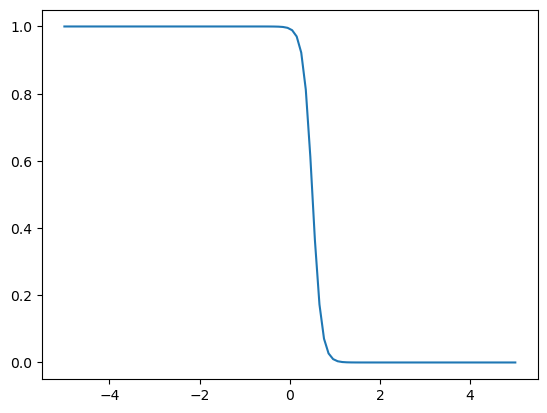

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f94a2e57e20>

In [64]:
plot(range(-5,5, length = 100), map(y->fermi(y-0.5, 0.1), range(-5,5, length = 100)))

In [135]:
function scf_n(scfprob::SingleLevelSCFproblem, nup, ndown)
    
    U = scfprob.U
    
    γL = scfprob.γL
    γR = scfprob.γR
    γ = γL + γR
    
    μL = scfprob.μL
    μR = scfprob.μR
    
    T = scfprob.T
    
    ϵup = scfprob.ϵ0 + U*ndown
    ϵdown = scfprob.ϵ0 + U*nup
    
    fup(E) = (fermi(E - μL, T)*γL + fermi(E - μR, T)*γR)/((E-ϵup)^2 + γ^2)/(2pi)
    avg_nup, err_nup = quadgk(fup, -Inf, Inf)
    
    fdown(E) = (fermi(E - μL, T)*γL + fermi(E - μR, T)*γR)/((E-ϵdown)^2 + γ^2)/(2pi)
    avg_ndown, err_down = quadgk(fdown, -Inf, Inf)
    
    return avg_nup, avg_ndown
end

scf_n (generic function with 1 method)

In [136]:
function solve_scf(scfprob, nup0, ndown0, abstol, maxiter, mixing)
    
    nup_old = nup0
    ndown_old = ndown0
    
    nup_new = nup0
    ndown_new = ndown0
    
    hist_up = Float64[]
    hist_down = Float64[]
    
    niter = 0
    error = 1.0
    
    while error > abstol
        
        if niter > maxiter
            @warn "Convergence failed, maximum number of iterations reached with error of $error"
            return (nup_new, ndown_new), (hist_up, hist_down)
        end
        
        nup_old = nup_new
        ndown_old = ndown_new
        
        nup_new, ndown_new = scf_n(scfprob, nup_old, ndown_old)
        
        nup_new = (1-mixing)*nup_new + mixing*nup_old
        ndown_new = (1-mixing)*ndown_new + mixing*ndown_old
        
        push!(hist_up, nup_new)
        push!(hist_down, ndown_new)
        
        error = max(abs(nup_new - nup_old), abs(ndown_new - ndown_old))
        niter +=1
        
    end
    
    return (nup_new, ndown_new), (hist_up, hist_down)
end
        

solve_scf (generic function with 2 methods)

In [214]:
Us = range(0.0, 0.8, step = 0.01)
probs = [SingleLevelSCFproblem(0.0, 0.005, 0.005, u, 0, 0.05, 0.05) for u in Us]
;

In [215]:
scf_sol = [solve_scf(prob, 0.1, 0.2, 1E-5, 7000, 0.9)[1] for prob in probs];

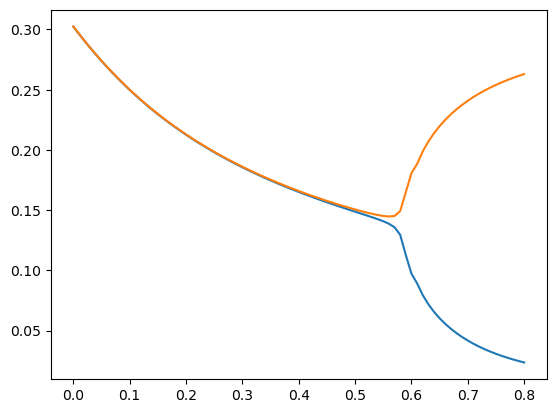

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f949267c940>

In [216]:
plot(Us, [x[1] for x in scf_sol])
plot(Us, [x[2] for x in scf_sol])

In [217]:
function transmitance(scfprob::SingleLevelSCFproblem, nup, ndown, E)
    U = scfprob.U
    
    γL = scfprob.γL
    γR = scfprob.γR
    γ = γL + γR
    
    ϵup = scfprob.ϵ0 + U*ndown
    ϵdown = scfprob.ϵ0 + U*nup
    
    return γL*γR/((E-ϵup)^2 + γ^2), γL*γR/((E-ϵdown)^2 + γ^2)
end

transmitance (generic function with 2 methods)

In [218]:
scf_sol[end][2]

0.26299056323603176

In [219]:
Es = range(-0.5, 0.5, step = 0.001)
trans = [transmitance(probs[end], scf_sol[end][1], scf_sol[end][2], E) for E in Es];

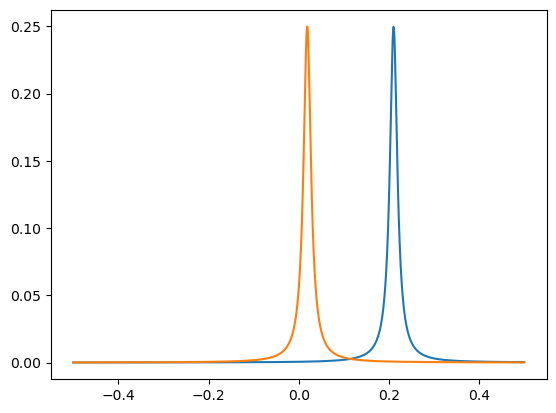

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9492592df0>

In [220]:
plot(Es, [t[1] for t in trans])
plot(Es, [t[2] for t in trans])